# City of Phoenix Crime

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import gmaps

#read in datafile, convert to dataframe
data = pd.DataFrame(pd.read_csv('Resources/crime-data.csv', low_memory=False)).drop(['100 BLOCK ADDR', 'OCCURRED TO'], axis=1)

#Data cleansing & manipulation
#datatypes
data['INC NUMBER'] = data['INC NUMBER'].apply(str).replace('\.0', '', regex=True)
data['OCCURRED ON'] = data['OCCURRED ON'].astype(str)
data['UCR CRIME CATEGORY'] = data['UCR CRIME CATEGORY'].astype(str)
data['ZIP'] = data['ZIP'].apply(str).replace('\.0', '', regex=True)
data['PREMISE TYPE'] = data['PREMISE TYPE'].astype(str)

#regroup/rename
data.loc[data['PREMISE TYPE'] == '07A STOREROOM/SHED (COMMERCIAL)', ['PREMISE TYPE']] = 'STOREROOM / SHED'
data.loc[data['PREMISE TYPE'] == '07A STOREROOM/SHED (RESIDENTIAL)', ['PREMISE TYPE']] = 'STOREROOM / SHED'
data.loc[data['PREMISE TYPE'] == 'BAR / LOUNG / NIGHT CLUB', ['PREMISE TYPE']] = 'BAR / LOUNGE / NIGHTCLUB'
data.loc[data['PREMISE TYPE'] == 'GARAGE / CARPORT', ['PREMISE TYPE']] = 'GARAGE'
data.loc[data['PREMISE TYPE'] == 'CARPORT', ['PREMISE TYPE']] = 'GARAGE'
data.loc[data['PREMISE TYPE'] == 'BUS', ['PREMISE TYPE']] = 'ON THE BUS'
data.loc[data['PREMISE TYPE'] == 'FAST FOOD STORE', ['PREMISE TYPE']] = 'RESTAURANT'
data.loc[data['PREMISE TYPE'] == 'FOJ - PREMISE UNKNOWN', ['PREMISE TYPE']] = 'UNKNOWN'
data.loc[data['PREMISE TYPE'] == 'HOSPITAL', ['PREMISE TYPE']] = 'HOSPITAL / NURSING CARE'
data.loc[data['PREMISE TYPE'] == 'SCHOOL-COLLEGE/UNIVERSITY', ['PREMISE TYPE']] = 'SCHOOL/COLLEGE/CHILDCARE'
data.loc[data['PREMISE TYPE'] == 'SCHOOL-ELEMENTARY/SECONDARY', ['PREMISE TYPE']] = 'SCHOOL/COLLEGE/CHILDCARE'
data.loc[data['PREMISE TYPE'] == 'SCHOOL-OTHER', ['PREMISE TYPE']] = 'SCHOOL/COLLEGE/CHILDCARE'
data.loc[data['PREMISE TYPE'] == 'SINGLE FAMILY HOUSING', ['PREMISE TYPE']] = 'SINGLE FAMILY HOUSE'
data.loc[data['PREMISE TYPE'] == 'STREET / ROADWAY / ALLEY SIDEWALK', ['PREMISE TYPE']] = 'STREET / ROADWAY / ALLEY / SIDEWALK'
data.loc[data['PREMISE TYPE'] == 'RAIL STATION', ['PREMISE TYPE']] = 'TRAIN STATION'
data.loc[data['PREMISE TYPE'] == 'WAREHOUSE / FACTORY', ['PREMISE TYPE']] = 'INDUSTRIAL SITE'

#clean up data
data = data[data['PREMISE TYPE'] != 'NaN']
data = data[data['PREMISE TYPE'] != '']
data = data[data['ZIP'] != 'NaN']
data = data[data['ZIP'] != '']
data = data[data['OCCURRED ON'] != 'NaN']
data = data[data['OCCURRED ON'] != '']
#data = data[data['INC NUMBER'] != 'NaN'
#data = data[data['INC NUMBER'] != '']
data = data[data['UCR CRIME CATEGORY'] != 'NaN']

data['OCCURRED ON'] = pd.to_datetime(data['OCCURRED ON'])

#parse & add columns for year/month/day 
#YEAR = data['INC NUMBER'].str[:4].astype(int) #Inc number does not correspondd with Occurred on year in all cases
YEAR = data['OCCURRED ON'].dt.year
data['YEAR'] = YEAR.fillna(0.0).astype(int)
#data = data.rename(columns = {'INC NUMBER':'YEAR'})

MONTH = data['OCCURRED ON'].dt.month
DAY = data['OCCURRED ON'].dt.day

data['MONTH'] = MONTH.fillna(0.0).astype(int)
data['DAY'] = DAY.fillna(0.0).astype(int)

dayofweek = data['OCCURRED ON'].dt.weekday_name
data['DayofWeek'] = dayofweek

data.head()

,INC NUMBER,OCCURRED ON,UCR CRIME CATEGORY,ZIP,PREMISE TYPE,YEAR,MONTH,DAY,DayofWeek
0,201500000000000,2015-11-01,MOTOR VEHICLE THEFT,85307,SINGLE FAMILY HOUSE,2015,11,1,Sunday
1,201500000000000,2015-11-01,MOTOR VEHICLE THEFT,85043,SINGLE FAMILY HOUSE,2015,11,1,Sunday
2,201600000000000,2015-11-01,MOTOR VEHICLE THEFT,85029,SINGLE FAMILY HOUSE,2015,11,1,Sunday
3,201500000000000,2015-11-01,LARCENY-THEFT,85014,PARKING LOT,2015,11,1,Sunday
4,201700000000000,2015-11-01,LARCENY-THEFT,85085,SINGLE FAMILY HOUSE,2015,11,1,Sunday


In [2]:
#remove year = 0 & 2015 (only 2 month of data)
data = data[data['YEAR'] > 2015] 
data.head()

,INC NUMBER,OCCURRED ON,UCR CRIME CATEGORY,ZIP,PREMISE TYPE,YEAR,MONTH,DAY,DayofWeek
10169,201700000000000,2016-01-01,RAPE,85017,SINGLE FAMILY HOUSE,2016,1,1,Friday
10170,201700000000000,2016-01-01,LARCENY-THEFT,85029,MOBILE HOME,2016,1,1,Friday
10171,201600000000000,2016-01-01,MOTOR VEHICLE THEFT,85041,DRIVEWAY,2016,1,1,Friday
10172,201600000000000,2016-01-01,RAPE,85051,nan,2016,1,1,Friday
10173,201600000000000,2016-01-01,LARCENY-THEFT,85053,APARTMENT,2016,1,1,Friday


# Most category/premise type

In [3]:
###Most common premise type for each crime category

cattype = data.groupby(['UCR CRIME CATEGORY', 'PREMISE TYPE']).count()[['OCCURRED ON']].sort_values(['UCR CRIME CATEGORY','OCCURRED ON'], ascending=False)#.nlargest(5,'OCCURRED ON')

#print(type(cattype))
cattype=cattype.rename(columns = {"OCCURRED ON":"OCCURRENCES"})

cattype=cattype.groupby(['UCR CRIME CATEGORY']).head(1).sort_values(by=['OCCURRENCES'], ascending=False)

cattype.to_csv ('PremiseTypeByCategory.csv', index=True, header=True)

cattype


,,OCCURRENCES
UCR CRIME CATEGORY,PREMISE TYPE,
BURGLARY,SINGLE FAMILY HOUSE,19085
LARCENY-THEFT,RETAIL BUSINESS,15968
MOTOR VEHICLE THEFT,PARKING LOT,6789
DRUG OFFENSE,STREET / ROADWAY / ALLEY / SIDEWALK,6131
AGGRAVATED ASSAULT,APARTMENT,4583
ROBBERY,STREET / ROADWAY / ALLEY / SIDEWALK,2642
RAPE,SINGLE FAMILY HOUSE,1079
ARSON,nan,693
MURDER AND NON-NEGLIGENT MANSLAUGHTER,SINGLE FAMILY HOUSE,101


# Most common premise type

In [4]:
###Most common premise type

premtype = data.groupby(['PREMISE TYPE']).count()[['OCCURRED ON']]

#cattype = cattype.reset_index().sort_values(['UCR CRIME CATEGORY','OCCURRED ON'],ascending=False).set_index(['UCR CRIME CATEGORY','PREMISE TYPE'])
premtype=premtype.rename(columns = {"OCCURRED ON":"OCCURRENCES"})

premtype = premtype.sort_values(by=['OCCURRENCES'], ascending=False)

premtype.to_csv ('PremiseType.csv', index=True, header=True)


premtype.head()

,OCCURRENCES
PREMISE TYPE,
SINGLE FAMILY HOUSE,44520
APARTMENT,27821
STREET / ROADWAY / ALLEY / SIDEWALK,25494
PARKING LOT,24345
RETAIL BUSINESS,18436


# Most common crime type

In [5]:
###Most common crime type

category = data.groupby(['UCR CRIME CATEGORY']).count()[['OCCURRED ON']]

category=category.rename(columns = {"OCCURRED ON":"OCCURRENCES"})

category = category.sort_values(by=['OCCURRENCES'], ascending=False)

category.to_csv ('category.csv', index=True, header=True)

category.head()
#data['UCR CRIME CATEGORY'].value_counts()

,OCCURRENCES
UCR CRIME CATEGORY,
LARCENY-THEFT,123438
BURGLARY,38680
MOTOR VEHICLE THEFT,25649
DRUG OFFENSE,20519
AGGRAVATED ASSAULT,18705


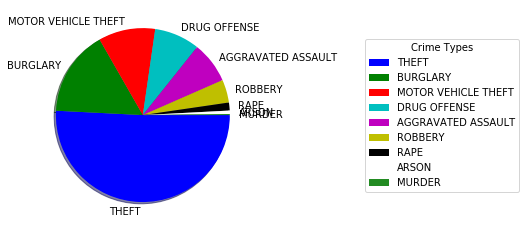

In [21]:
datacat = data["UCR CRIME CATEGORY"].groupby(data["UCR CRIME CATEGORY"]).count().sort_values(ascending=False)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'forestgreen']
labels = ['THEFT', 'BURGLARY', 'MOTOR VEHICLE THEFT', 'DRUG OFFENSE', 'AGGRAVATED ASSAULT', 'ROBBERY', 'RAPE', 'ARSON', 'MURDER']
plt.pie(datacat, colors=colors, labels=labels, counterclock=False, shadow=True)
plt.legend(labels,
          title="Crime Types",
          loc="center left",
          bbox_to_anchor=(1.5, 0, 0.5, 1))
plt.show()

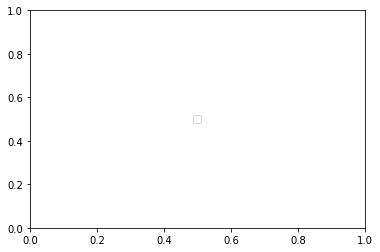

# Crime type by year

In [22]:
weekday = data.groupby(['YEAR','DayofWeek']).count()[['OCCURRED ON']]
weekday 

OCCURRED ON
YEAR DayofWeek             
2016 Friday            9875
     Monday            8860
     Saturday          8754
     Sunday            7747
     Thursday          9244
     Tuesday           9289
     Wednesday         9423
2017 Friday           10023
     Monday            9378
     Saturday          9116
     Sunday            8752
     Thursday          9576
     Tuesday           9478
     Wednesday         9689
2018 Friday            9730
     Monday            9642
     Saturday          8913
     Sunday            8515
     Thursday          9453
     Tuesday           9301
     Wednesday         9203
2019 Friday            7424
     Monday            6883
     Saturday          6783
     Sunday            6194
     Thursday          7336
     Tuesday           7205
     Wednesday         7185

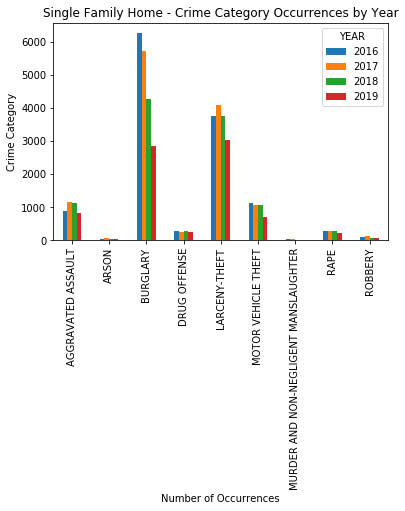

In [23]:
###Most common crime in single family house

prem = data[data['PREMISE TYPE'] == "SINGLE FAMILY HOUSE"] 
premgroup = prem.groupby(['UCR CRIME CATEGORY', 'YEAR']).count()['OCCURRED ON'].reset_index()
premgrouppivot = premgroup.pivot(index='UCR CRIME CATEGORY', columns='YEAR', values='OCCURRED ON')
premgrouppivot.plot(kind='bar')
plt.xlabel("Number of Occurrences")
plt.ylabel("Crime Category")
plt.title("Single Family Home - Crime Category Occurrences by Year")
plt.savefig("Single Family Home - Crime Category Occurrences by Year.png", bbox_inches='tight')

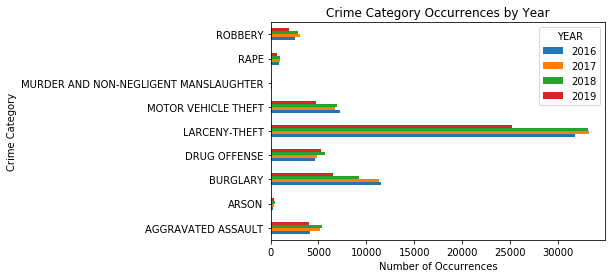

In [24]:
#most common crime each year
catyear = data.groupby(['YEAR','UCR CRIME CATEGORY']).count()['OCCURRED ON'].reset_index()
catyearpivot = catyear.pivot(index='UCR CRIME CATEGORY', columns='YEAR', values='OCCURRED ON')
catyearpivot.plot(kind='barh')
plt.xlabel("Number of Occurrences")
plt.ylabel("Crime Category")
plt.title("Crime Category Occurrences by Year")
plt.savefig("Crime Category Occurrences by Year.png", bbox_inches='tight')

# Most Crime prone zip

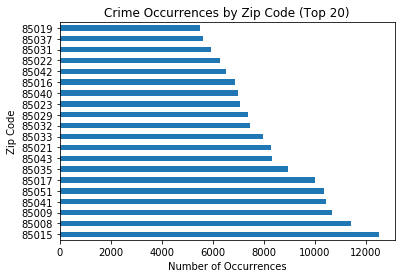

In [25]:
#total by zip
#5 - Most crime-prone ZIP
datazip = data["ZIP"].groupby(data["ZIP"]).count().sort_values(ascending=False)
datazip.head(20).plot(kind="barh")
plt.xlabel("Number of Occurrences")
plt.ylabel("Zip Code")
plt.title("Crime Occurrences by Zip Code (Top 20)")
plt.savefig("Crime Rates by Zip Code.png")

# Crime by month

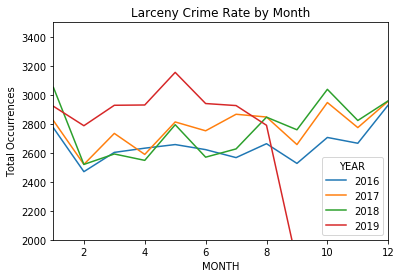

In [26]:
#4 - Relationship between crimes and date
#larceny (highest crime) by month
larceny =  data['UCR CRIME CATEGORY']=="LARCENY-THEFT"
datalarceny = data[larceny]

crimemonth = datalarceny.groupby(['YEAR','MONTH']).count()['OCCURRED ON'].reset_index()

crimemonthpivot = crimemonth.pivot(index='MONTH', columns='YEAR', values='OCCURRED ON')
crimemonthpivot.plot(kind='line')
plt.xlim(1,12)
plt.ylim(2000, 3500)
plt.title("Larceny Crime Rate by Month")
plt.ylabel("Total Occurrences")
plt.savefig("Larceny Rates by Month.png")

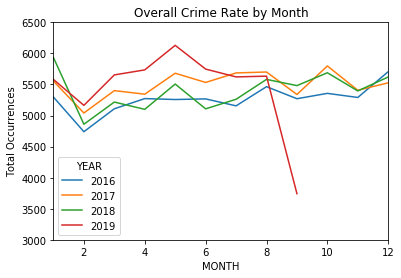

In [27]:
#4 - Relationship between crimes and date
#all crime by month
allcrimemonth = data.groupby(['YEAR','MONTH']).count()['OCCURRED ON'].reset_index()

allcrimemonth = allcrimemonth.pivot(index='MONTH', columns='YEAR', values='OCCURRED ON')
allcrimemonth.plot(kind='line')
plt.xlim(1,12)
plt.ylim(3000, 6500)
plt.title("Overall Crime Rate by Month")
plt.ylabel("Total Occurrences")
plt.savefig("Overall Crime Rates by Month.png")

In [28]:
concise = pd.DataFrame(data.drop(['INC NUMBER', 'OCCURRED ON', 'PREMISE TYPE', 'YEAR', 'MONTH', 'DAY', 'DayofWeek'], axis=1).groupby('ZIP')['UCR CRIME CATEGORY'].count()).sort_values(['UCR CRIME CATEGORY'], ascending=False)
concise.head()

,UCR CRIME CATEGORY
ZIP,
85015,12517
85008,11416
85009,10671
85041,10445
85051,10352


# Relationship between housing price and crime rate

In [29]:
housing = pd.DataFrame(pd.read_csv('Resources/housing-data.csv'))
housing['ZIP'] = housing['ZIP'].apply(str).replace('\.0', '', regex=True)
housing.groupby(['ZIP'])
merged = pd.merge(concise, housing, on="ZIP", how='outer')
merged.columns = ['ZIP','Number of Occurrences','Percent Change']
merged.drop([71], inplace=True)
pd.to_numeric(merged['Number of Occurrences'])
merged.dtypes

ZIP                       object
Number of Occurrences    float64
Percent Change           float64
dtype: object

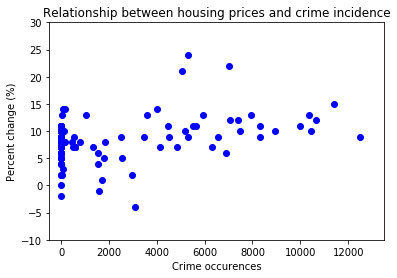

In [30]:
plt.scatter(merged['Number of Occurrences'], merged['Percent Change'], marker="o", facecolors="blue")
plt.title('Relationship between housing prices and crime incidence')
plt.xlabel('Crime occurences')
plt.ylabel('Percent change (%)')
plt.xlim(-500, 13500)
plt.ylim(-10, 30)
plt.savefig("ReducedRelationship.png")
plt.show()

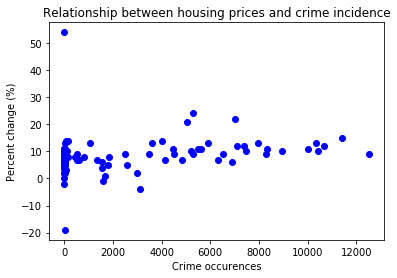

In [31]:
plt.scatter(merged['Number of Occurrences'], merged['Percent Change'], marker="o", facecolors="blue")
plt.title('Relationship between housing prices and crime incidence')
plt.xlabel('Crime occurences')
plt.ylabel('Percent change (%)')
plt.savefig("GlobalRelationship.png")
plt.show()

# Zip code map

In [32]:
# Access maps with unique API key
gmaps.configure(api_key="sb`s key")
# Create a list containing coordinates
coordinates = [
   (33.498308, -112.101216),
   (33.473225, -111.995941),
   (33.459762, -112.116117),
   (33.390954, -112.121464),
   (33.564601, -112.133803),
   (33.500310, -112.121432),
   (33.472840, -112.211914),
   (33.427081, -112.193438),
   (33.562115, -112.088647),
   (33.490222, -112.219086),
   (33.622469, -111.996970),
   (33.596344, -112.096274),
   (33.631265, -112.096491),
   (33.398969, -112.029268),
   (33.507124, -112.031649),
   (33.379962, -112.017409),
   (33.626129, -112.042762),
   (33.495601, -112.166627),
   (33.495264, -112.257191),
   (33.507946, -112.146488)
]
# Customize the size of the figure
figure_layout = {
   'width': '400px',
   'height': '300px',
   'border': '1px solid black',
   'padding': '1px',
   'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout)
markers = gmaps.marker_layer(coordinates)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='300px', margin='0 auto 0 auto', padding='1px', wi…